In [38]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

#Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os
if not os.path.isfile(caffe_root + 
                      'models/bvlc_reference_caffenet/caffenet_train_iter_120000.caffemodel'):
    print("The caffemodel file is missing.")

In [2]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
               caffe_root + 'models/bvlc_reference_caffenet/caffenet_train_iter_120000.caffemodel',
               caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 
                                     'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0, 255] range instead of [0, 1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [3]:
# set net to batch size of 50
net.blobs['data'].reshape(50, 3, 227, 227)

In [4]:
# test on image without pathologies
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/38-1170.jpg'))
out = net.forward()
print("Predicted class is #{}.".format(out['prob'][0].argmax()))
# that's a mistake

Predicted class is #1.


In [5]:
# test on image with pathologies (fibrosis)
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/f3-3315.jpg'))
out = net.forward()
print("Predicted class is #{}.".format(out['prob'][0].argmax()))

Predicted class is #1.


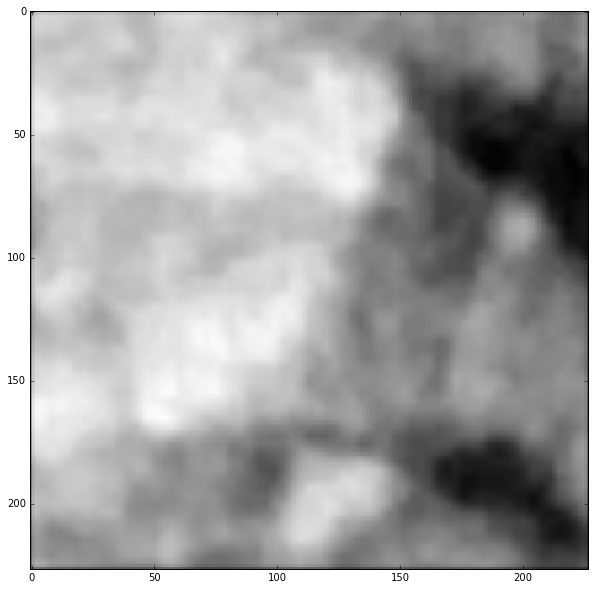

In [6]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

In [7]:
# load labels
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try: 
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    print ("Something is wrong with labels file.")

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1]
print labels[top_k]

1 fibrosis


In [32]:
# CPU mode
net.forward()  # call once for allocation
%timeit net.forward()

1 loop, best of 3: 5.46 s per loop


In [8]:
# GPU mode 
caffe.set_device(0)
caffe.set_mode_gpu()
net.forward()  # call once for allocation 
%timeit net.forward()

1 loop, best of 3: 439 ms per loop


In [9]:
[(k, v.data.shape) for k,v in net.blobs.items()] # 1 is the batch size

[('data', (50, 3, 227, 227)),
 ('conv1', (50, 96, 55, 55)),
 ('pool1', (50, 96, 27, 27)),
 ('norm1', (50, 96, 27, 27)),
 ('conv2', (50, 256, 27, 27)),
 ('pool2', (50, 256, 13, 13)),
 ('norm2', (50, 256, 13, 13)),
 ('conv3', (50, 384, 13, 13)),
 ('conv4', (50, 384, 13, 13)),
 ('conv5', (50, 256, 13, 13)),
 ('pool5', (50, 256, 6, 6)),
 ('fc6', (50, 4096)),
 ('fc7', (50, 4096)),
 ('fc8', (50, 1000)),
 ('prob', (50, 1000))]

In [10]:
# The parameters and their shapes. The parameters are net.params['name'][0]
# while biases are net.params['name'][1]
[(k, v[0].data.shape) for k,v in net.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (4096, 9216)),
 ('fc7', (4096, 4096)),
 ('fc8', (1000, 4096))]

In [31]:
# Helper functions for visualization

# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0, fl=False):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0,0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n,n) + data.shape[1:]).transpose((0,2,1,3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    if not fl:
        plt.imshow(data)
    else:
        #plt.rcParams['figure.figsize'] = (20, 20)
        plt.imshow(data, origin='lower')

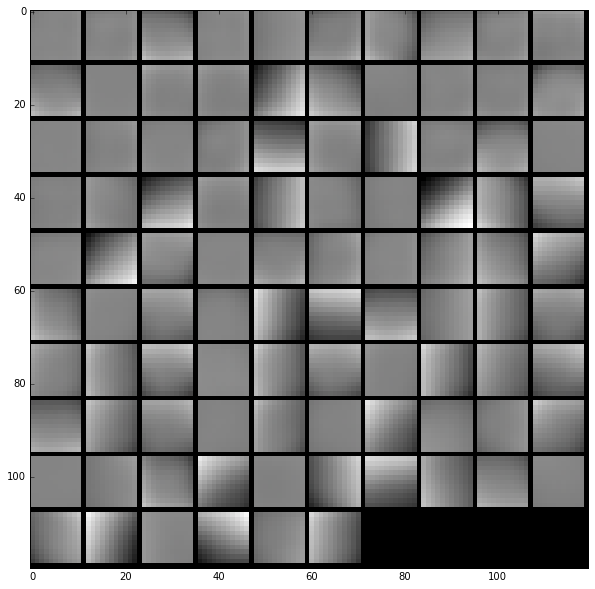

In [37]:
# The first layer filters, conv1
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0,2,3,1))

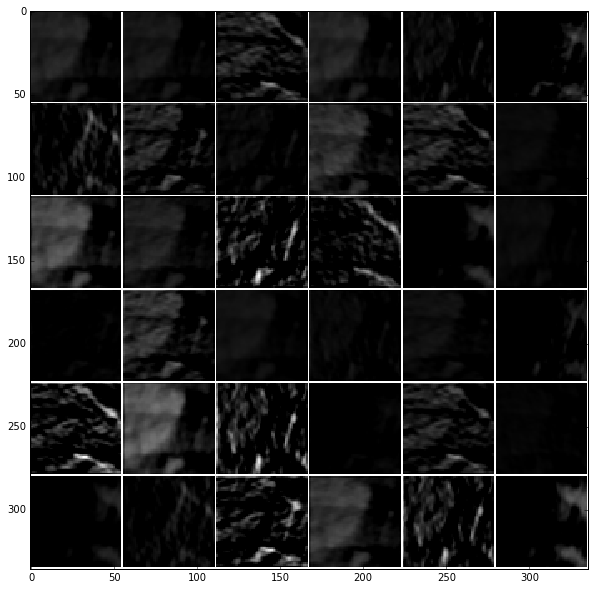

In [41]:
# The first layer output, conv1 (rectified responses of the filters above, first 36 only)
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat, padval=1)

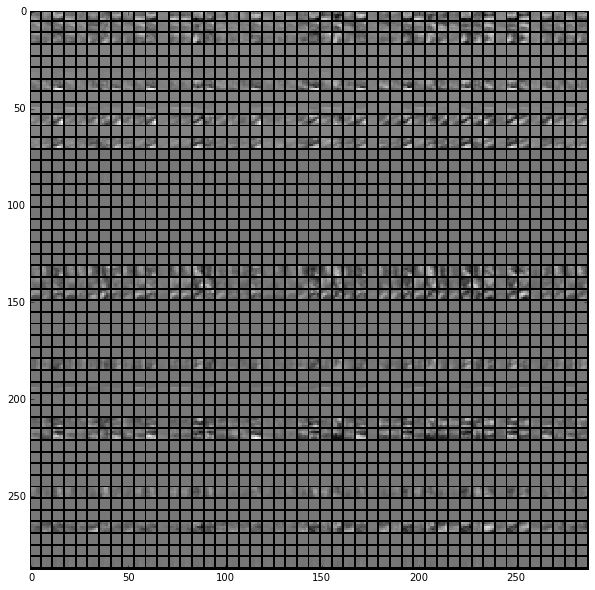

In [85]:
# The second layer filters, conv2
filters = net.params['conv2'][0].data
#vis_square(filters[:12].reshape(12**2, 10, 10))
vis_square(filters[:48].reshape(48**2, 5, 5))
#vis_square(filters.transpose(0,2,3,1))

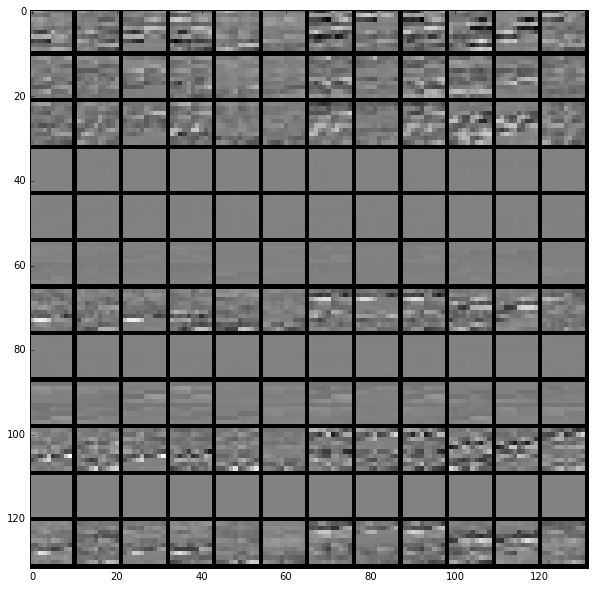

In [86]:
filters = net.params['conv2'][0].data
vis_square(filters[:12].reshape(12**2, 10, 10))

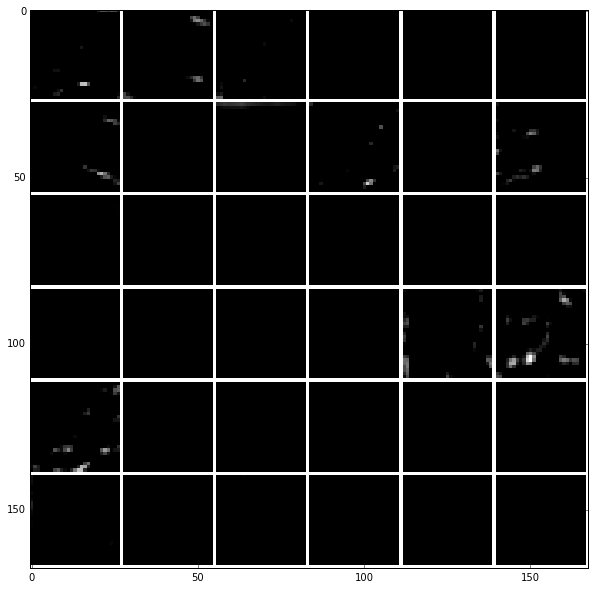

In [52]:
# The second layer output, conv2 (rectified, only the first 36 of 256 channels)
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

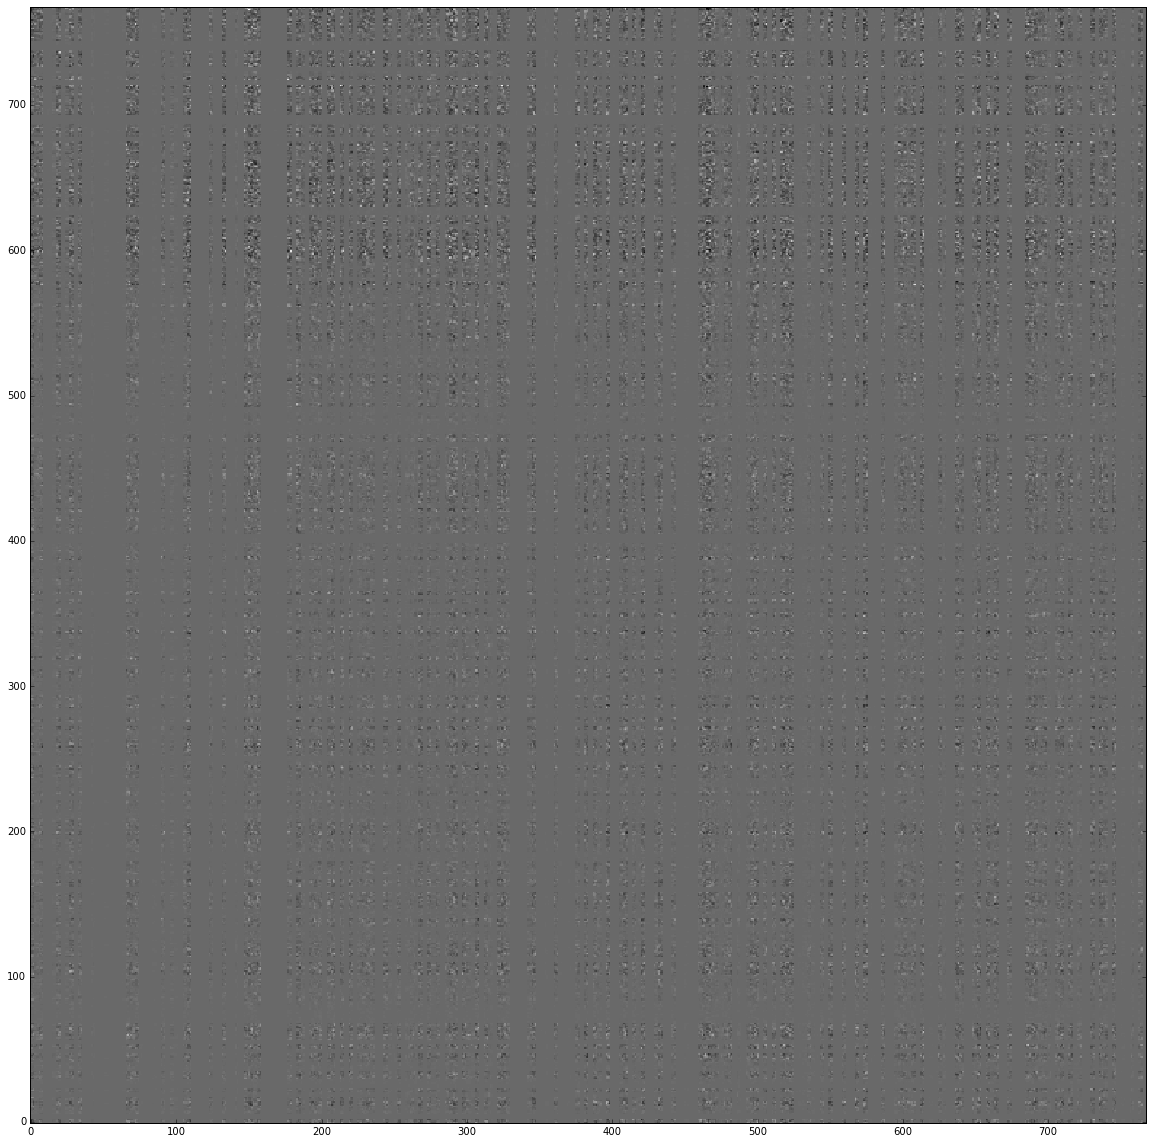

In [36]:
# The third layer filters, conv3
filters = net.params['conv3'][0].data
vis_square(filters[:256].reshape(256**2, 3, 3),padsize=0, padval=0, fl=True)

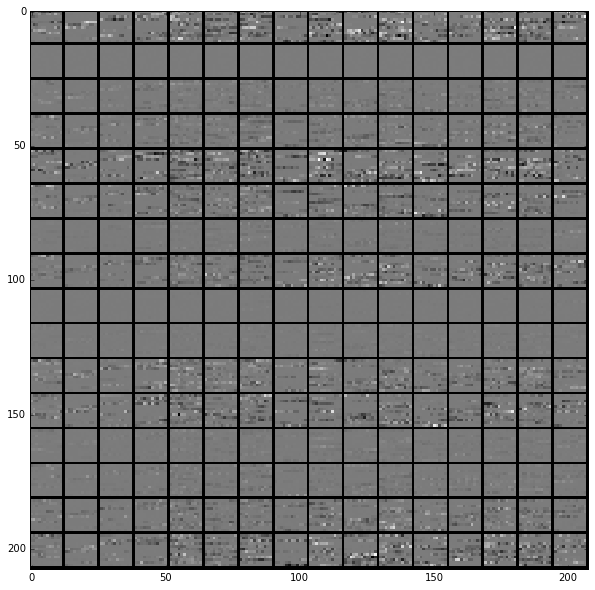

In [54]:
# The third layer filters, conv3
filters = net.params['conv3'][0].data
vis_square(filters[:16].reshape(16**2, 12, 12))

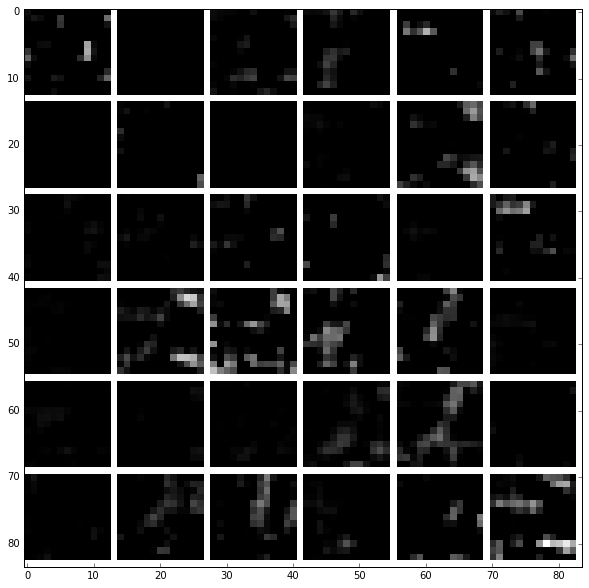

In [61]:
# The third layer output, conv3 (rectified, only the first 36 channels)
feat = net.blobs['conv3'].data[0, :36]
vis_square(feat, padval=1)

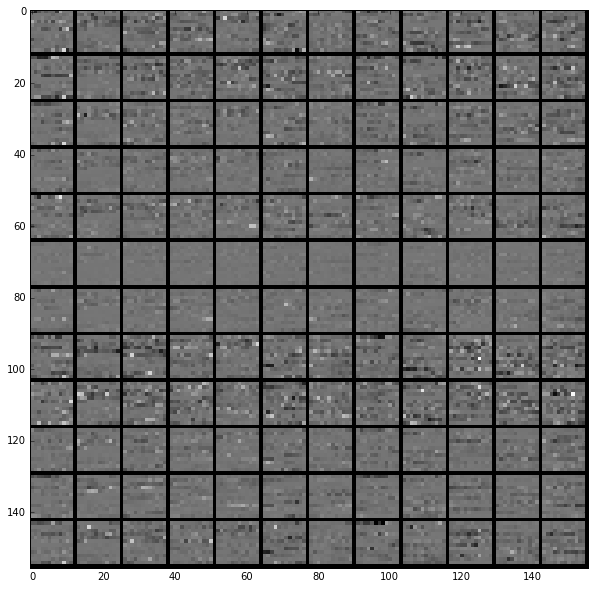

In [69]:
# The fourth layer filters, conv4
filters = net.params['conv4'][0].data
vis_square(filters[:12].reshape(12**2, 12, 12))

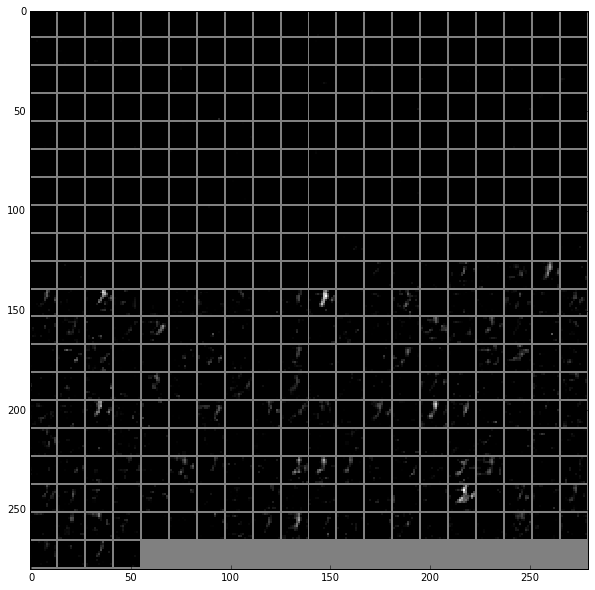

In [70]:
# The fourth layer output, conv4 (rectified, all 384 channels)
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)

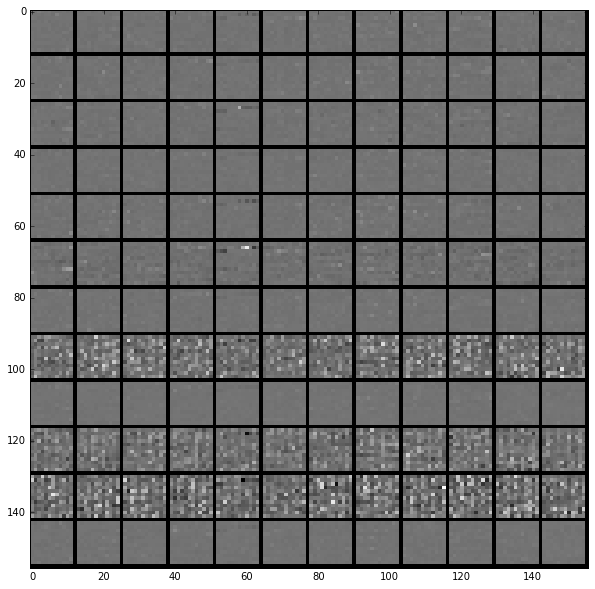

In [71]:
# The fifth layer filters, conv5
filters = net.params['conv5'][0].data
vis_square(filters[:12].reshape(12**2, 12, 12))

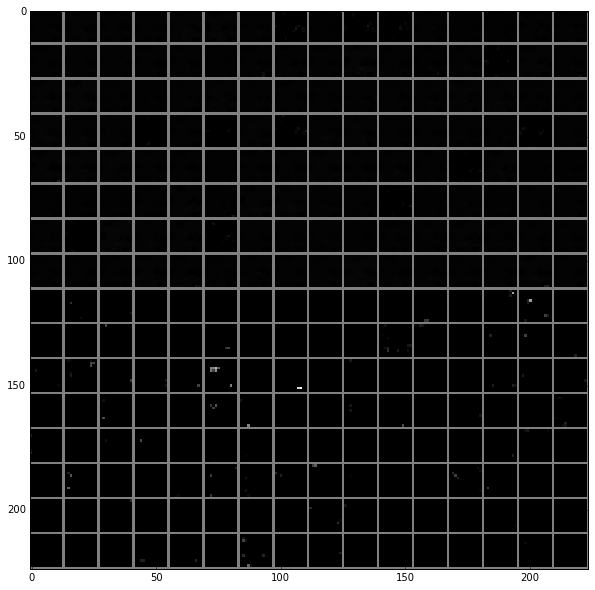

In [72]:
# The fifth layer output, conv5 (rectified, all 256 channels)
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)

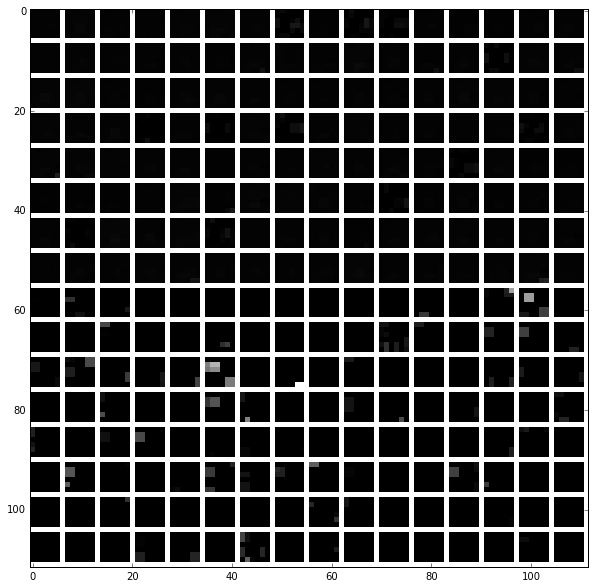

In [73]:
# The fifth layer after pooling, pool5 
feat = net.blobs['pool5'].data[0]
vis_square(feat, padval=1)

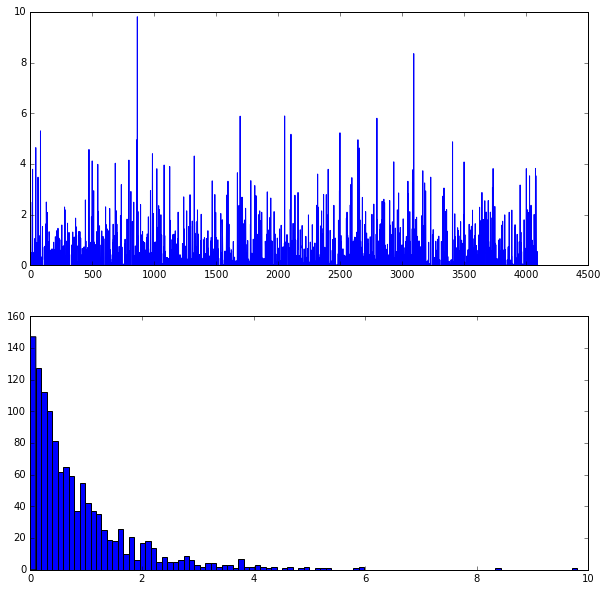

In [74]:
# The first fully connected layer, fc6 (rectified)
# We show the output values and the histogram of the positive values
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins = 100)

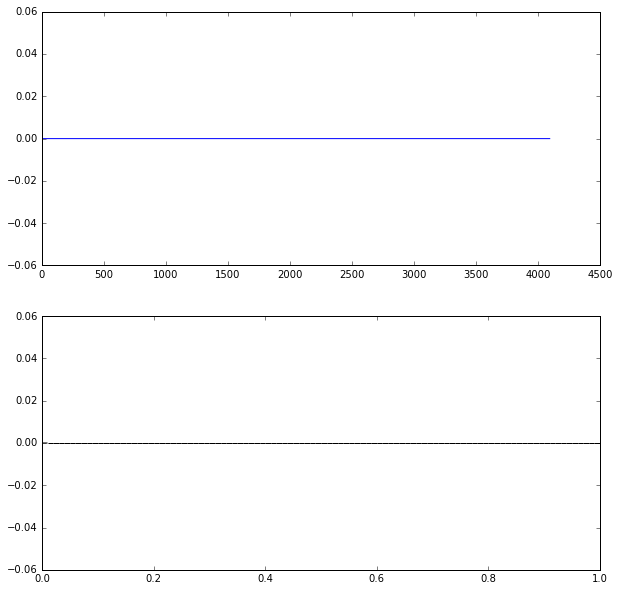

In [78]:
# The second fully connected layer, fc7 (rectified)
feat = net.blobs['fc7'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

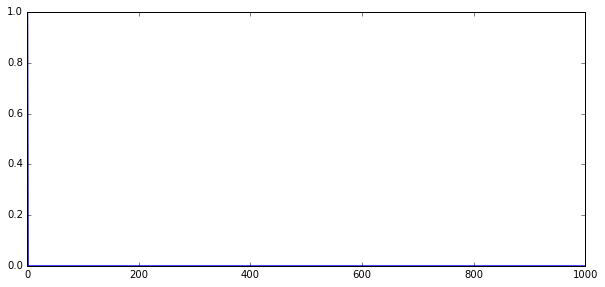

In [83]:
# The final probability output, prob
feat = net.blobs['prob'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)

In [81]:
print net.blobs['prob'].data[0].flatten().argsort()[-1]

1
